In [ ]:
#COPYRIGHT UBAYD KHAN 2020. All rights reserved in accordance with the
#following four-clause BSD license.

In [ ]:
#Redistribution and use in source and binary forms, with or without
#modification, are permitted provided that the following conditions are met:
#1. Redistributions of source code must retain the above copyright
#   notice, this list of conditions and the following disclaimer.
#2. Redistributions in binary form must reproduce the above copyright
#   notice, this list of conditions and the following disclaimer in the
#   documentation and/or other materials provided with the distribution.
#3. All advertising materials mentioning features or use of this software
#   must display the following acknowledgement:
#   This product includes software developed by the <organization>.
#4. Neither the name of the Ubayd Khan nor the
#   names of its contributors may be used to endorse or promote products
#   derived from this software without specific prior written permission.
#
#THIS SOFTWARE IS PROVIDED BY UBAYD KHAN ''AS IS'' AND ANY
#EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
#WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
#DISCLAIMED. IN NO EVENT SHALL UBAYD KHAN BE LIABLE FOR ANY
#DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
#(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
#LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
#ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
#(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
#SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import cv2
from PIL import Image, ImageEnhance

In [2]:
import import_ipynb
import NeuralNetwork3 as neural

importing Jupyter notebook from NeuralNetwork3.ipynb


In [3]:
def separateFraction(box,origWidth,origHeight,image):
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    boxH = h
        
    #denominator
    y = y + h
    h = origHeight - (origHeight - y)
    roi = image[y:y+h, x:x+w]
    cv2.imwrite("separated/denom.png", roi)
    cv2.imwrite("data/denom.png", roi)
    denom = reconstructExpression("denom.png")
    
    #numerator
    h = (origHeight-h) -boxH
    y = y - boxH - h
    roi = image[y:y+h, x:x+w]
    cv2.imwrite("separated/num.png", roi)
    cv2.imwrite("data/num.png", roi)
    num = reconstructExpression("num.png")

    #rest
    x = x + w
    w = origWidth-x
    h = origHeight
    roi = image[y:y+h, x:x+w]
    cv2.imwrite("separated/rest.png", roi)
    cv2.imwrite("data/rest.png", roi)
    rest = reconstructExpression("rest.png")
    
    returnString = "frac("+num+","+denom+")"+rest

    return returnString

In [4]:
def checkFractionBar(aR):
    if(aR>=5.00):
        return True

In [5]:
def checkSquareRoot(box,prevBox):
    if(prevBox[0]<=(box[0]+box[2])<=(prevBox[0]+prevBox[2])):
        if(prevBox[1]<=(box[1]+box[3])<=(prevBox[1]+prevBox[3])):
            return True

In [6]:
def checkExponent(centroid,prevCentroid):
    if(centroid[0]>prevCentroid[0]):
        if(centroid[1]<prevCentroid[1]-60):
            return True

In [7]:
def reconstructExpression(fileName):
    boundingBox = []
    centroid = []
    finalString = ""
    carryRoot = False
    carryExp = False
    charFound = False
    
    #increase brightness
    im = Image.open("data/" + fileName)
    enhancer = ImageEnhance.Brightness(im)
    enhanced_im = enhancer.enhance(1.5)
    enhanced_im.save("data/bright.png")

    # read the image
    image = cv2.imread("data/bright.png")

    origWidth, origHeight, channels = image.shape

    # apply greyscale filter onto image
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # apply a blur to remove noise from the image
    image_grey = cv2.GaussianBlur(image_grey, (7, 7), 0)

    # threshold image to inverted binary - black and white only
    ret, thresh1 = cv2.threshold(image_grey ,127,255,cv2.THRESH_BINARY_INV)
    # dilate image to make white portions thicker
    image_dilate = cv2.dilate(thresh1, None, iterations=2)

    cv2.imwrite("separated/PROCESSED.png",image_dilate)

    # find ALL contours in the image
    contours = cv2.findContours(image_dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    original = image.copy()
    i = 0

    for contour in contours:
        # if contour area is too small, ignore it
        if(cv2.contourArea(contour) < 1000): continue

        # bounding rectangles placed on all contours detected
        x,y,w,h = cv2.boundingRect(contour)
        if w*h < 25: continue

        # region of interest taken from contour - we are interested in the contents of the rectangle only
        roi = image[y:y+h, x:x+w]

        boundingBox.insert(i, [x,y,w,h])

        centroidX = (x+w)/2
        centroidY = (y+h)/2

        centroid.insert(i, [centroidX,centroidY])

        # save the contents of each rectangle as a separate PNG image
        cv2.imwrite("separated/roi"+ str(i) + ".png", roi)

        i = i + 1

    #bubble sort
    for passNum in range(0,i):
        for c in range(0, i-passNum-1):
            if(boundingBox[c][0]>boundingBox[c+1][0]):
                temp = boundingBox[c]
                boundingBox[c] = boundingBox[c+1]
                boundingBox[c+1] = temp
                temp2 = centroid[c]
                centroid[c] = centroid[c+1]
                centroid[c+1] = temp2
    
    for n in range(0,i): 
        charFound = False
        aspectRatio = (boundingBox[n][2]/boundingBox[n][3])
        
        #square roots
        if(n>0):
            if(checkSquareRoot(boundingBox[n],boundingBox[n-1])==True):
                finalString = finalString + "sqrt("
                charFound = True
                carryRoot=True
                carryRootBox=n-1
                
            #exponents
            elif(checkExponent(centroid[n],centroid[n-1])==True):
                finalString = finalString + "exp("
                charFound = True
                carryExp=True
                carryExpBox=n-1
        
        #fractions
        if(checkFractionBar(aspectRatio)==True):
            finalString = finalString + separateFraction(boundingBox[n],origWidth,origHeight,image)
            charFound = True
            break
        
        #carry check for roots
        if(carryRoot==True and carryExp==False):
            if(checkSquareRoot(boundingBox[n],boundingBox[carryRootBox])==True):
                finalString = finalString + "C"
                if(n==i-1):
                    finalString = finalString + ")"
                    carryRoot=False
            else:
                finalString = finalString + ")"
                carryRoot=False
                
        #carry check for exponents
        if(carryExp==True):
            if(checkExponent(centroid[n],centroid[carryExpBox])==True):
                finalString = finalString + "C"
                if(n==i-1):
                    finalString = finalString + ")"
                    carryExp=False
            else:
                finalString = finalString + ")"
                carryExp=False
        
        if(charFound == False):
            fileName = "roi"+ str(n) +".png"
            finalString = finalString + str(neural.identifyChar(fileName))
    return finalString 


In [8]:
def main():
    expression = reconstructExpression("fraction.jpg")
    print(expression)
    cv2.waitKey(0)
    

Loading image...
Predicted value: 5
Loading image...
Predicted value: 4
Loading image...
Predicted value: 4
Loading image...
Predicted value: 7
frac(447,5)


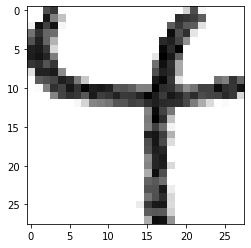

In [9]:
if __name__ == "__main__":
    main()